In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Display the first few rows
print(df.head())


Saving train_interpolated_combined.csv to train_interpolated_combined.csv
   frame_index     id_13_team_0     id_10_team_0      id_2_team_0  \
0            0  6625.72,3757.64  6403.82,2864.24  5862.48,4511.28   
1            1  6628.83,3766.36  6409.45,2823.42  5856.28,4504.88   
2            2  6637.97,3776.86  6417.07,2812.24  5850.84,4519.38   
3            3  6642.03,3774.37  6417.58,2806.16  5842.62,4522.95   
4            4  6644.41,3765.87  6419.77,2720.71  5841.73,4508.15   

       id_4_team_0     id_16_team_0    id_281_team_0      id_5_team_0  \
0  4678.01,4176.14   4010.38,2694.8  9375.74,3115.76  6260.37,5207.12   
1  4658.56,4160.23  4028.67,2701.89  9375.74,3115.76  6273.72,5204.59   
2  4636.28,4163.52  4053.03,2690.15  9375.74,3115.76  6287.83,5210.19   
3  4606.58,4170.88   4078.76,2710.4  9375.74,3115.76  6306.81,5209.68   
4  4580.09,4140.56  4101.08,2714.68  9375.74,3115.76  6320.51,5212.53   

       id_1_team_0     id_45_team_0  ...     id_11_team_1      id_3_team

In [3]:
# Load the new CSV file with interpolated data
df = pd.read_csv('train_interpolated_combined.csv')

# Melt to long format for easy manipulation
df_long = df.melt(id_vars=["frame_index"], var_name="entity", value_name="position")

# Split 'position' into 'x' and 'y'
df_long[['x', 'y']] = df_long['position'].str.split(',', expand=True).astype(float)

# Helpers to extract player ID and team
def extract_id(entity):
    parts = entity.split('_')
    if entity == 'ball' or len(parts) < 3:
        return None
    return parts[1]

def extract_team(entity):
    parts = entity.split('_')
    if entity == 'ball' or len(parts) < 3:
        return None
    return parts[-1]

# Add classification columns
df_long["type"] = df_long["entity"].apply(lambda x: 'ball' if x == 'ball' else 'player')
df_long["id"] = df_long["entity"].apply(extract_id)
df_long["team"] = df_long["entity"].apply(extract_team)

# Normalize positions
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
df_long['x_norm'] = scaler_x.fit_transform(df_long[['x']])
df_long['y_norm'] = scaler_y.fit_transform(df_long[['y']])

# Pivot to wide format for model input
pivot_x = df_long.pivot(index='frame_index', columns='entity', values='x_norm')
pivot_y = df_long.pivot(index='frame_index', columns='entity', values='y_norm')

# Sort columns for consistency
pivot_x = pivot_x.sort_index(axis=1)
pivot_y = pivot_y.sort_index(axis=1)

# Track sorted entity names
entities = pivot_x.columns
sorted_entities = list(entities)

# Interleave x and y columns for LSTM input
interleaved_data = np.empty((pivot_x.shape[0], pivot_x.shape[1] * 2))
for idx, ent in enumerate(sorted_entities):
    interleaved_data[:, idx * 2] = pivot_x[ent].values
    interleaved_data[:, idx * 2 + 1] = pivot_y[ent].values

In [4]:

sequence_length = 10

# Generate full sequences
X, y = [], []
for i in range(len(interleaved_data) - sequence_length):
    X.append(interleaved_data[i:i+sequence_length])
    y.append(interleaved_data[i+sequence_length])

X = np.array(X)
y = np.array(y)

# 80/20 split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Build a more complex LSTM model with multiple LSTM layers
model = Sequential([
    LSTM(128, input_shape=(sequence_length, X_train.shape[2]), return_sequences=True),
    LSTM(64, return_sequences=False),  # Stacked LSTM layer
    Dropout(0.2),
    Dense(X_train.shape[2]),
    ReLU()  # Ensures all predicted coordinates are >= 0
])

# Compile the model
model.compile(optimizer=Adam(0.0005), loss='mse', metrics=['mae'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.2485 - mae: 0.4302 - val_loss: 0.1264 - val_mae: 0.2590
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1272 - mae: 0.2789 - val_loss: 0.0955 - val_mae: 0.2117
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0969 - mae: 0.2349 - val_loss: 0.0801 - val_mae: 0.1861
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0824 - mae: 0.2121 - val_loss: 0.0577 - val_mae: 0.1641
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0594 - mae: 0.1847 - val_loss: 0.0289 - val_mae: 0.1161
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0417 - mae: 0.1572 - val_loss: 0.0225 - val_mae: 0.1166
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0336 - mae: 0.1442 - val_loss: 0.0123 - val_mae: 0.0934
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0274 - mae: 0.1303 - val_loss: 0.0099 - val_mae: 0.0821
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0249 -

In [12]:
# Define train/test split and sequence length
sequence_length = 10
train_frames = int(0.8 * len(interleaved_data))
predict_frames = len(interleaved_data) - train_frames

# Start from last 10 frames of training
input_seq = interleaved_data[train_frames - sequence_length:train_frames].copy()
predicted_frames = []

# Predict all future frames
for i in range(predict_frames):
    input_reshaped = input_seq[-sequence_length:].reshape(1, sequence_length, -1)
    next_frame = model.predict(input_reshaped, verbose=0)[0]
    predicted_frames.append(next_frame)
    input_seq = np.vstack([input_seq, next_frame])

# Reverse normalization
predicted_frames = np.array(predicted_frames)
reversed_predictions = []

for frame in predicted_frames:
    unnormalized_frame = []
    for i in range(0, len(frame), 2):
        x = scaler_x.inverse_transform(frame[i].reshape(-1, 1))[0][0]
        y = scaler_y.inverse_transform(frame[i+1].reshape(-1, 1))[0][0]
        unnormalized_frame.extend([x, y])
    reversed_predictions.append(unnormalized_frame)

# Create DataFrame
output_columns = []
for ent in sorted(entities):
    output_columns.append(f"{ent}_x")
    output_columns.append(f"{ent}_y")

pred_df = pd.DataFrame(reversed_predictions, columns=output_columns)

# Dynamic frame range
pred_df.insert(0, "frame", range(train_frames, train_frames + len(pred_df)))
pred_df.to_csv(f"predicted_frames_{train_frames}_to_{train_frames + len(pred_df) - 1}.csv", index=False)
print(f"✅ Saved: predicted_frames_{train_frames}_to_{train_frames + len(pred_df) - 1}.csv")


✅ Saved: predicted_frames_436_to_544.csv


In [7]:
# Reverse normalization for ground truth (actual values)
actual_gt = interleaved_data[train_frames:]
actual_gt_unnorm = []

for frame in actual_gt:
    unnormalized_frame = []
    for i in range(0, len(frame), 2):
        x = scaler_x.inverse_transform(frame[i].reshape(-1, 1))[0][0]
        y = scaler_y.inverse_transform(frame[i + 1].reshape(-1, 1))[0][0]
        unnormalized_frame.extend([x, y])
    actual_gt_unnorm.append(unnormalized_frame)

actual_gt_unnorm = np.array(actual_gt_unnorm)


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

predictions = model.predict(X_test)

# Unnormalize
predictions_un = scaler_x.inverse_transform(predictions[:, ::2]), scaler_y.inverse_transform(predictions[:, 1::2])
y_test_un = scaler_x.inverse_transform(y_test[:, ::2]), scaler_y.inverse_transform(y_test[:, 1::2])

# Flatten to calculate MAE, RMSE, etc.
preds_flat = np.column_stack(predictions_un).flatten()
actuals_flat = np.column_stack(y_test_un).flatten()

mae = mean_absolute_error(actuals_flat, preds_flat)
mse = mean_squared_error(actuals_flat, preds_flat)
rmse = np.sqrt(mse)
r2 = r2_score(actuals_flat, preds_flat)

print(f"\n📊 Evaluation Metrics:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

📊 Evaluation Metrics:
MAE:  516.2812
MSE:  468888.1579
RMSE: 684.7541
R²:   0.8364


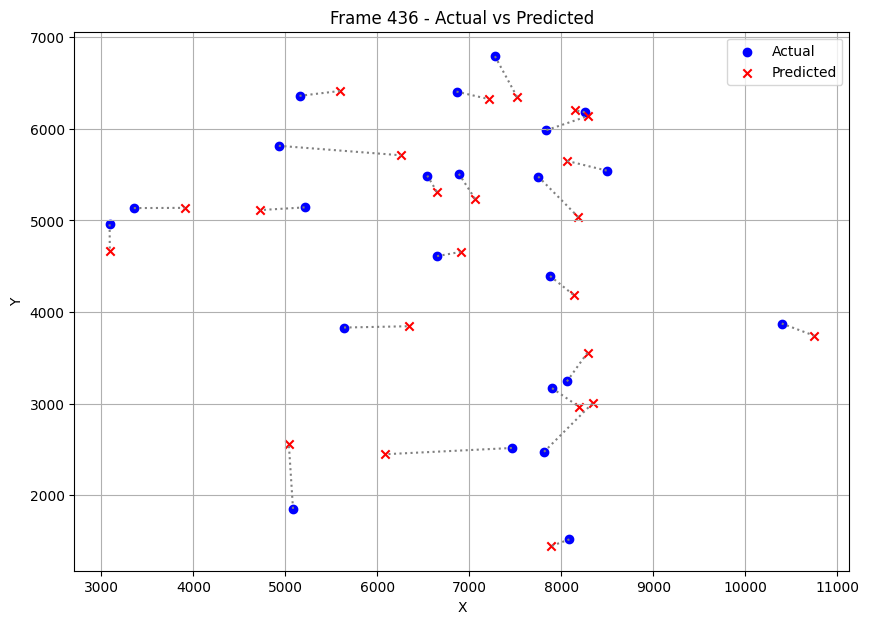

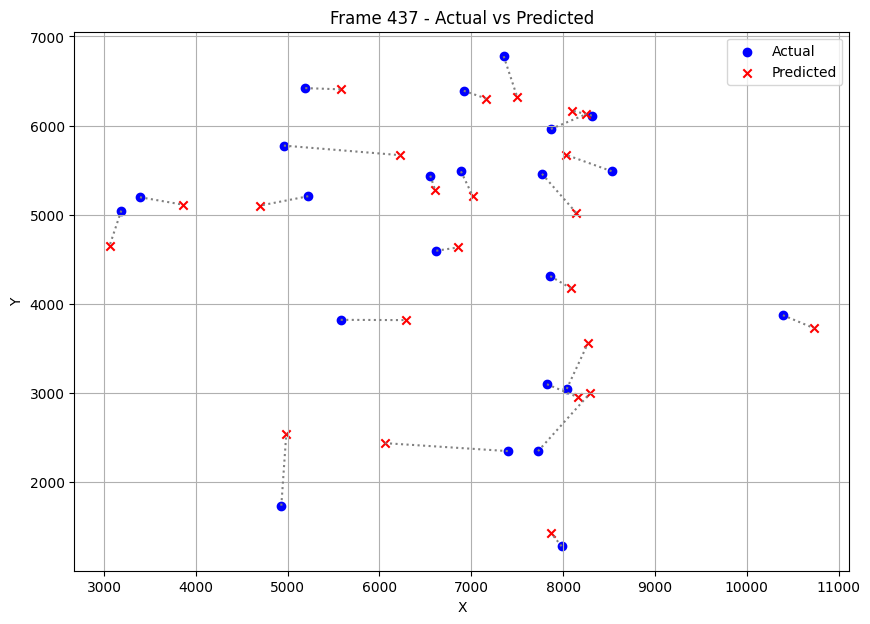

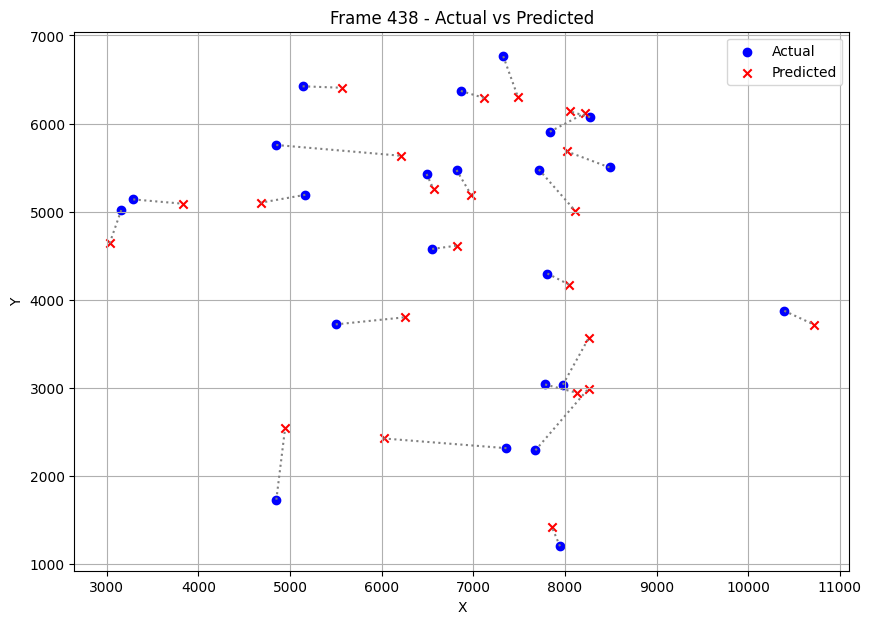

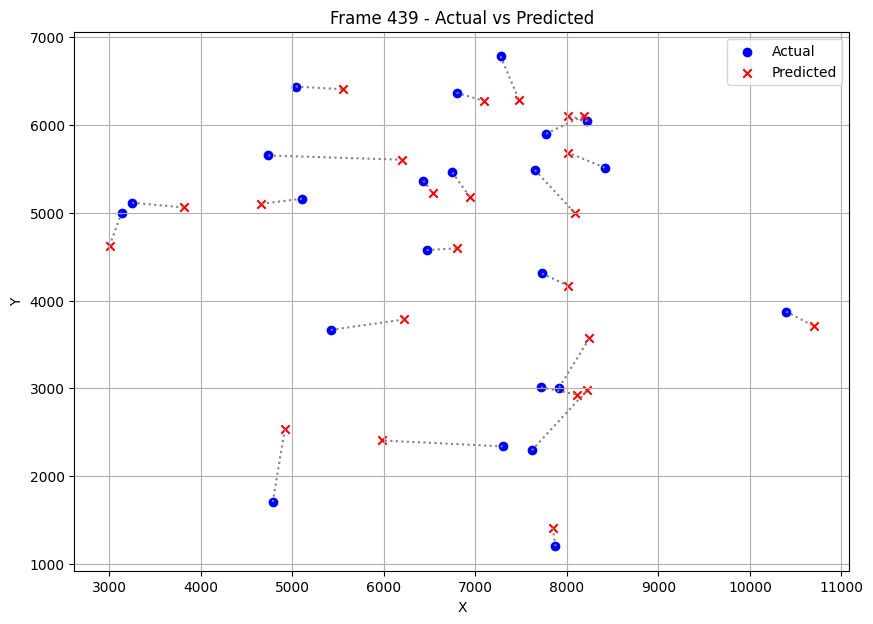

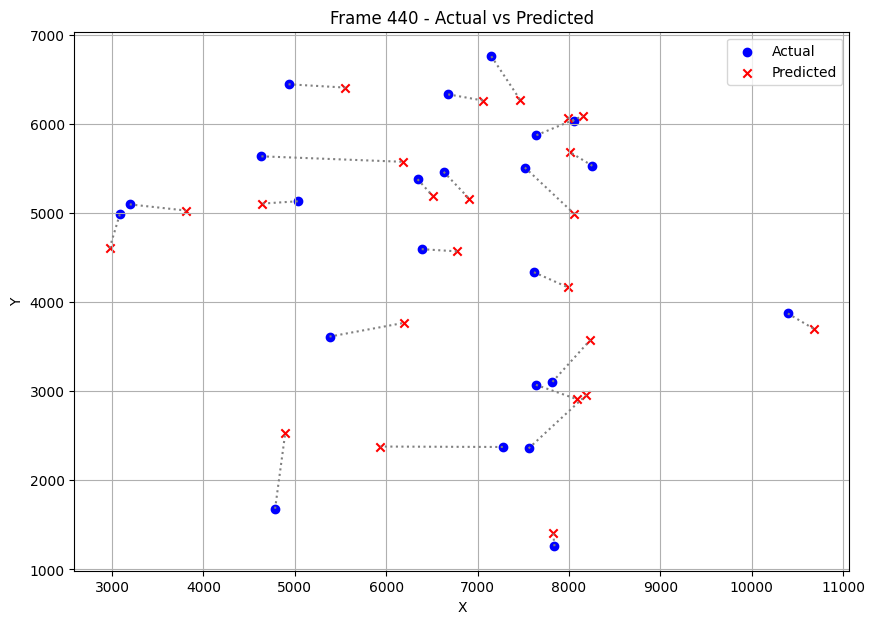

In [14]:
import matplotlib.pyplot as plt

num_entities = predicted_frames.shape[1] // 2
sample_frames = 5

for i in range(sample_frames):
    plt.figure(figsize=(10, 7))
    for j in range(num_entities):
        pred_x = reversed_predictions[i][j * 2]
        pred_y = reversed_predictions[i][j * 2 + 1]
        act_x = actual_gt_unnorm[i][j * 2]
        act_y = actual_gt_unnorm[i][j * 2 + 1]

        plt.scatter(act_x, act_y, color='blue', label='Actual' if j == 0 else "")
        plt.scatter(pred_x, pred_y, color='red', marker='x', label='Predicted' if j == 0 else "")
        plt.plot([act_x, pred_x], [act_y, pred_y], color='gray', linestyle='dotted')

    plt.title(f"Frame {train_frames + i} - Actual vs Predicted")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.legend()
    plt.show()


🔍 Entity Index 7 corresponds to: id_16_team_0


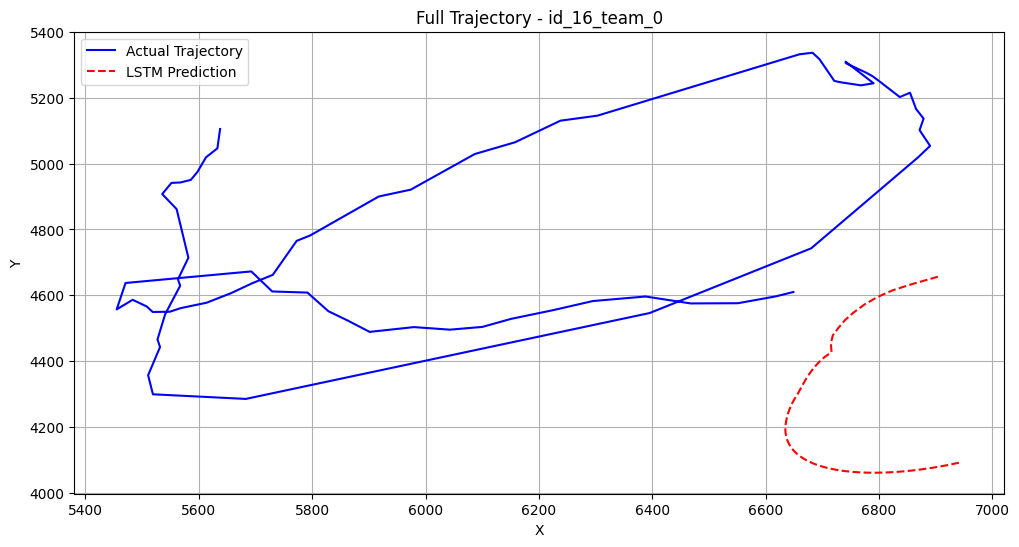

In [20]:
# Example plot for a specific entity
entity_index = 7  # Change this to inspect others
print(f"🔍 Entity Index {entity_index} corresponds to: {sorted_entities[entity_index]}")

# You must have variables `reversed_predictions` and `actual_gt_unnorm` defined before this.
pred_xs = [frame[entity_index * 2] for frame in reversed_predictions]
pred_ys = [frame[entity_index * 2 + 1] for frame in reversed_predictions]
true_xs = [frame[entity_index * 2] for frame in actual_gt_unnorm]
true_ys = [frame[entity_index * 2 + 1] for frame in actual_gt_unnorm]

plt.figure(figsize=(12, 6))
plt.plot(true_xs, true_ys, label='Actual Trajectory', color='blue')
plt.plot(pred_xs, pred_ys, label='LSTM Prediction', color='red', linestyle='--')
plt.title(f"Full Trajectory - {sorted_entities[entity_index]}")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

